---
title: Removing batch effect using Canonical Correlation Analysis for E13.5 and E17.5 datasets.
authors:
- saksham.malhotra@elucidata.io
tags:
- Seurat
- Single_Cell_RNA
- CCA
created_at: 2018-08-24
updated_at: 2018-08-24 
tldr: This removes batch effect through CCA on 13th day and 17th day raw data
---

In [4]:
library(Seurat)
library(dplyr)
library(Matrix)
packageVersion("Seurat")
# set plot widths for the notebook
library(repr)
options(repr.plot.width=13, repr.plot.height=9)

[1] ‘2.3.0’

### Download 17th day and 13th day datasets from GEO

In [9]:
system("wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE107nnn/GSE107122/suppl/GSE107122_RAW.tar", intern = TRUE)
system("tar -xvf GSE107122_RAW.tar", intern = TRUE)
system("gunzip GSM2861514_E175_Only_Cortical_Cells_DGE.txt.gz")
system("gunzip GSM2861511_E135_Only_Cortical_Cells_DGE.txt.gz")

character(0)

[1] "GSM2861510_E115_All_Cells_DGE.txt.gz"          
[2] "GSM2861510_E115_Only_Cortical_Cells_DGE.txt.gz"
[3] "GSM2861511_E135_All_Cells_DGE.txt.gz"          
[4] "GSM2861511_E135_Only_Cortical_Cells_DGE.txt.gz"
[5] "GSM2861514_E175_All_Cells_DGE.txt.gz"          
[6] "GSM2861514_E175_Only_Cortical_Cells_DGE.txt.gz"

### Read 13th and 17th day datasets and get highly variable genes

In [10]:
E135_Cortical_data=read.table("GSM2861511_E135_Only_Cortical_Cells_DGE.txt",sep="\t",header=TRUE,row.names=1)

In [11]:
E175_Cortical_data=read.table("GSM2861514_E175_Only_Cortical_Cells_DGE.txt",sep="\t",header=TRUE,row.names=1)

In [12]:
E135_Cortical_raw <- CreateSeuratObject(raw.data = E135_Cortical_data, min.cells = 3, min.genes = 200, project = "E135_Cortical")
mito.genes <- grep(pattern = "^MT-", x = rownames(x = E135_Cortical_raw@data), value = TRUE)
percent.mito <- Matrix::colSums(E135_Cortical_raw@raw.data[mito.genes, ]) / Matrix::colSums(E135_Cortical_raw@raw.data)
E135_Cortical_raw <- AddMetaData(object = E135_Cortical_raw, metadata = percent.mito, col.name = "percent.mito")
E135_Cortical_raw <- NormalizeData(object = E135_Cortical_raw)
E135_Cortical_raw <- ScaleData(object = E135_Cortical_raw, vars.to.regress = 'nUMI')
E135_Cortical_raw <- FindVariableGenes(object = E135_Cortical_raw, do.plot = FALSE)

[1] "Regressing out nUMI"
  |======================================================================| 100%
Time Elapsed:  27.3158462047577 secs
[1] "Scaling data matrix"
  |======================================================================| 100%


In [13]:
E175_Cortical_raw <- CreateSeuratObject(raw.data = E175_Cortical_data, min.cells = 3, min.genes = 200, project = "E175_Cortical")
mito.genes <- grep(pattern = "^MT-", x = rownames(x = E175_Cortical_raw@data), value = TRUE)
percent.mito <- Matrix::colSums(E175_Cortical_raw@raw.data[mito.genes, ]) / Matrix::colSums(E175_Cortical_raw@raw.data)
E175_Cortical_raw <- AddMetaData(object = E175_Cortical_raw, metadata = percent.mito, col.name = "percent.mito")
E175_Cortical_raw <- NormalizeData(object = E175_Cortical_raw)
E175_Cortical_raw <- ScaleData(object = E175_Cortical_raw, vars.to.regress = 'nUMI')
E175_Cortical_raw <- FindVariableGenes(object = E175_Cortical_raw, do.plot = FALSE)

[1] "Regressing out nUMI"
  |======================================================================| 100%
Time Elapsed:  19.8256022930145 secs
[1] "Scaling data matrix"
  |======================================================================| 100%


### Combine highly variable genes from two datasets

In [14]:
hvg_E135_Cortical_raw<- rownames(x = head(x = E135_Cortical_raw@hvg.info, n = 2000))
hvg_E175_Cortical_raw <- rownames(x = head(x = E175_Cortical_raw@hvg.info, n = 2000))
hvg.union <- union(x = hvg_E135_Cortical_raw, y = hvg_E175_Cortical_raw)

# lastly, we set the 'protocol' in each dataset for easy identification
# later it will be transferred to the merged object in RunCCA
E135_Cortical_raw@meta.data[, "protocol"] <- "E135"
E175_Cortical_raw@meta.data[, "protocol"] <- "E175"

### Run CCA

In [15]:
E135_E175_CCA <- RunCCA(object = E135_Cortical_raw, object2 = E175_Cortical_raw, genes.use = hvg.union, add.cell.id1 = 'E135', 
               add.cell.id2 = 'E175')

[1] "Scaling data matrix"
  |======================================================================| 100%


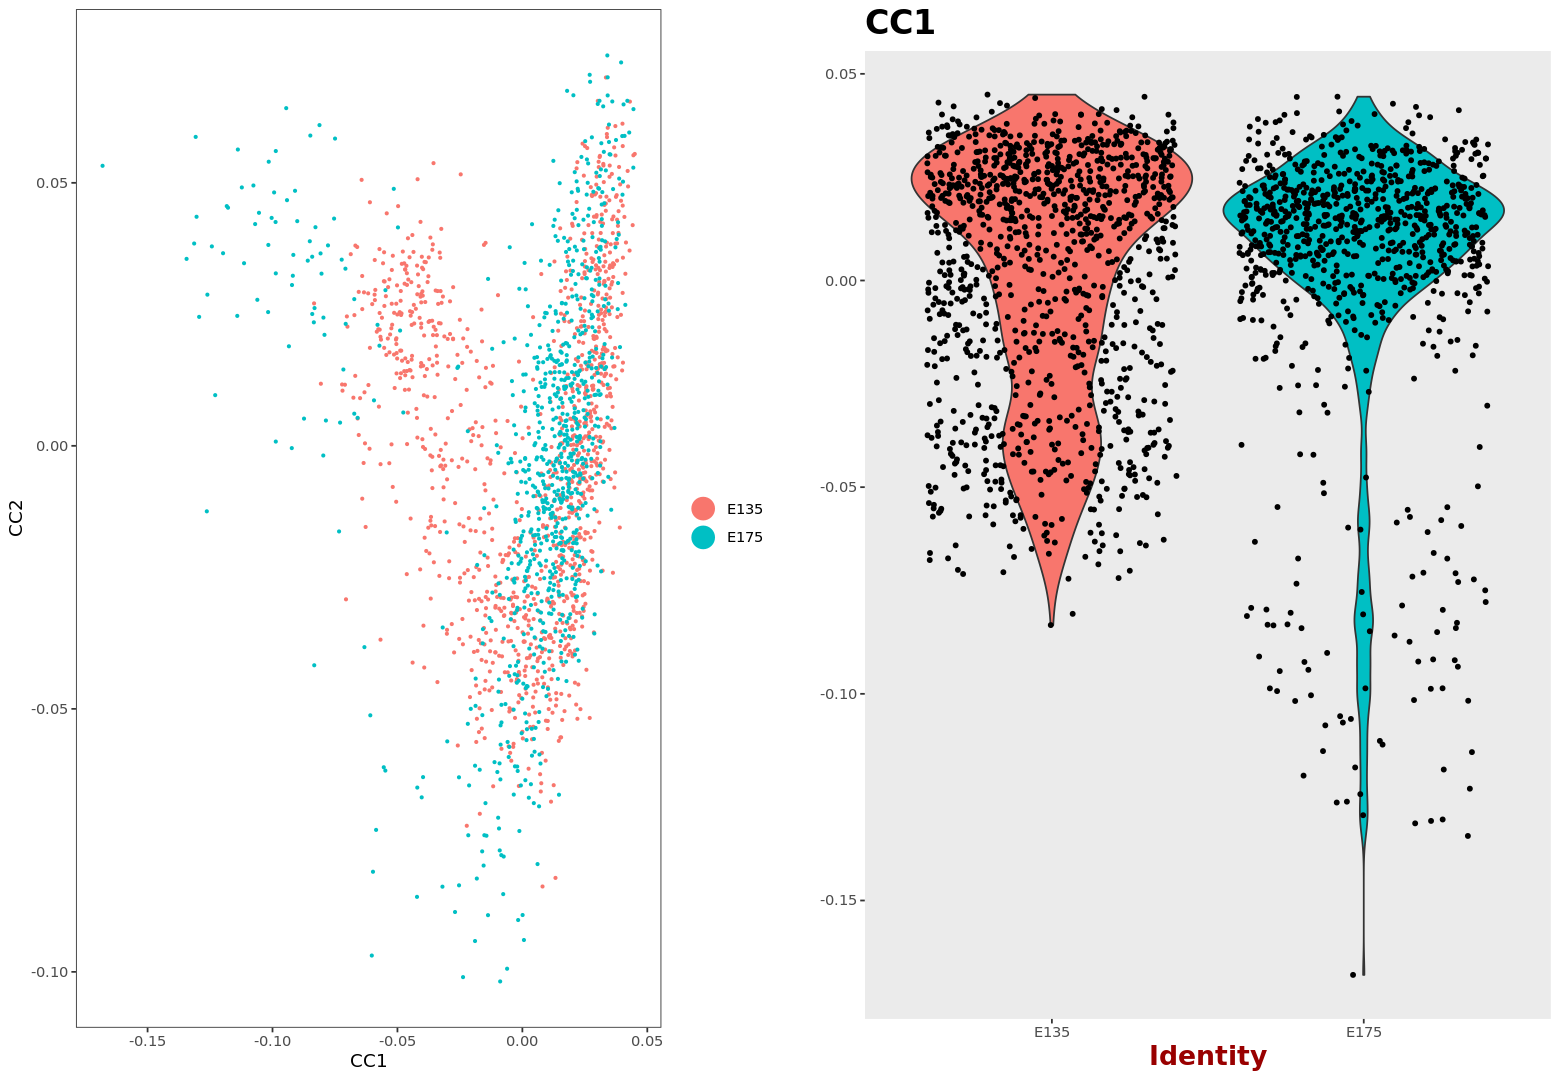

In [16]:
p1 <- DimPlot(object = E135_E175_CCA, reduction.use = "cca", group.by = "protocol", pt.size = 0.5, 
    do.return = TRUE)
p2 <- VlnPlot(object = E135_E175_CCA, features.plot = "CC1", group.by = "protocol", do.return = TRUE)
plot_grid(p1, p2)

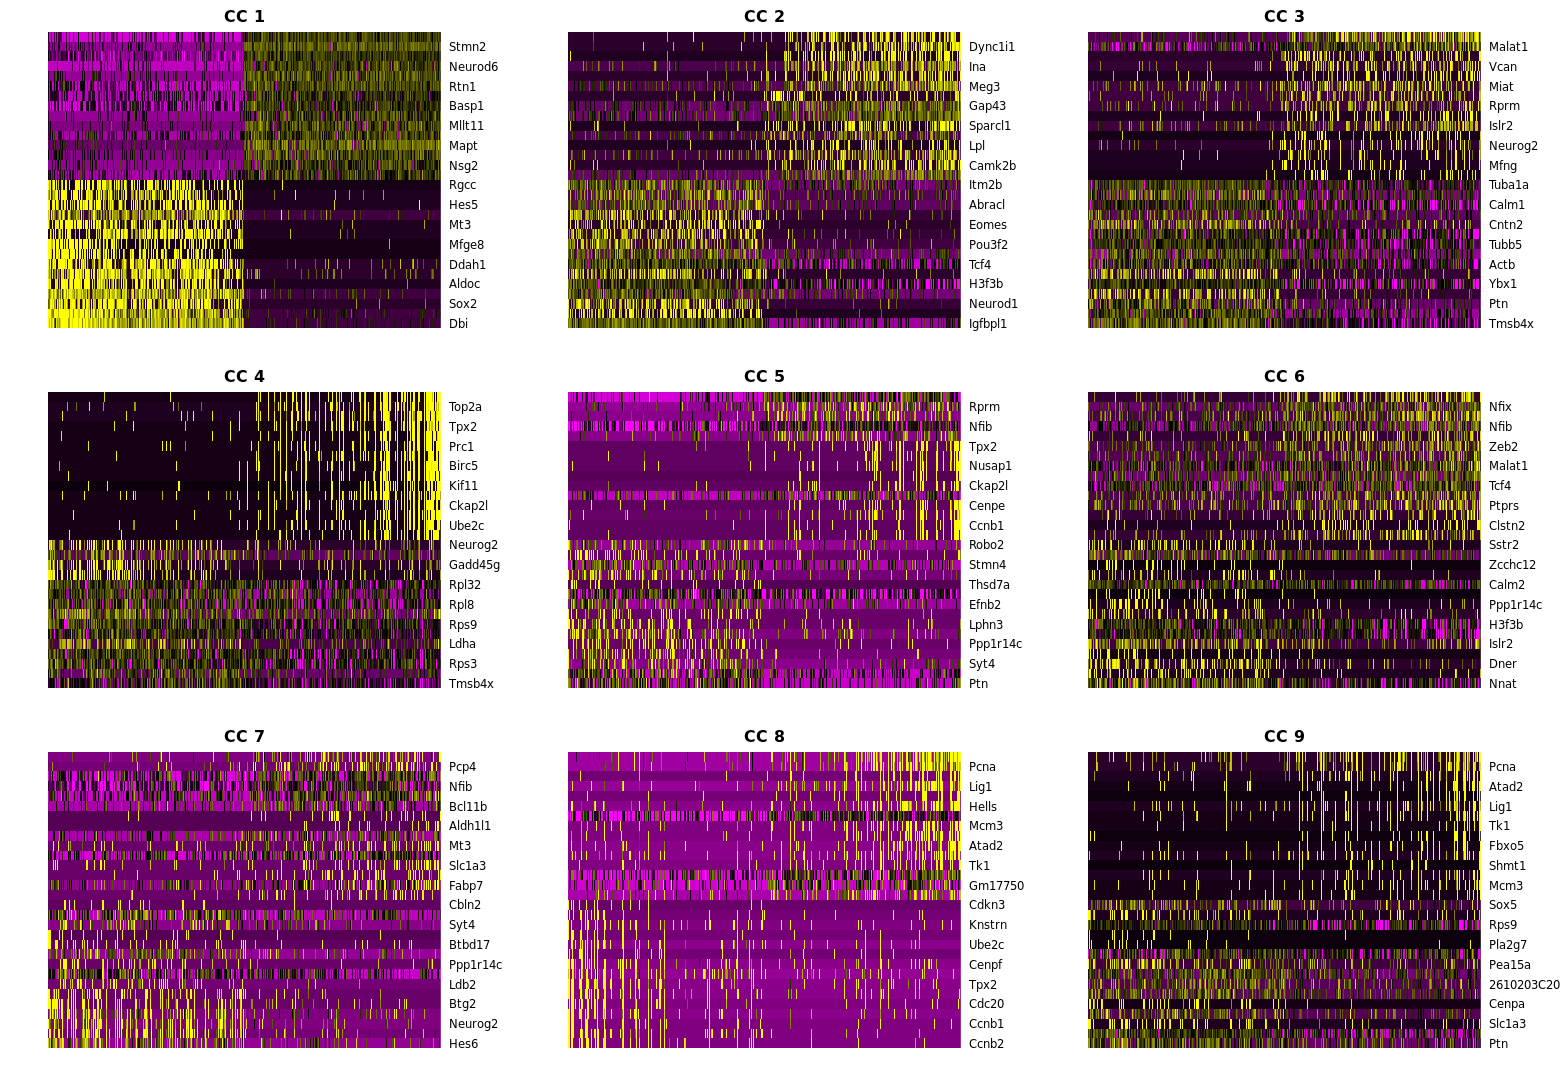

In [18]:
DimHeatmap(object = E135_E175_CCA, reduction.type = "cca", cells.use = 500, dim.use = 1:9, do.balanced = TRUE)

In [19]:
E135_E175_CCA <- CalcVarExpRatio(object = E135_E175_CCA, reduction.type = "pca", grouping.var = "protocol", dims.use = 1:15)

In [21]:
E135_E175_CCA_all_save <- E135_E175_CCA
E135_E175_CCA <- SubsetData(object = E135_E175_CCA, subset.name = "var.ratio.pca", accept.low = 0.5)

In [22]:
E135_E175_CCA_discard <- SubsetData(object = E135_E175_CCA_all_save, subset.name = "var.ratio.pca", accept.high = 0.5)
median(x = E135_E175_CCA@meta.data[, "nGene"])

[1] 1346.5

In [25]:
E135_E175_CCA <- AlignSubspace(object = E135_E175_CCA, reduction.type = "cca", grouping.var = "protocol", dims.align = 1:13)

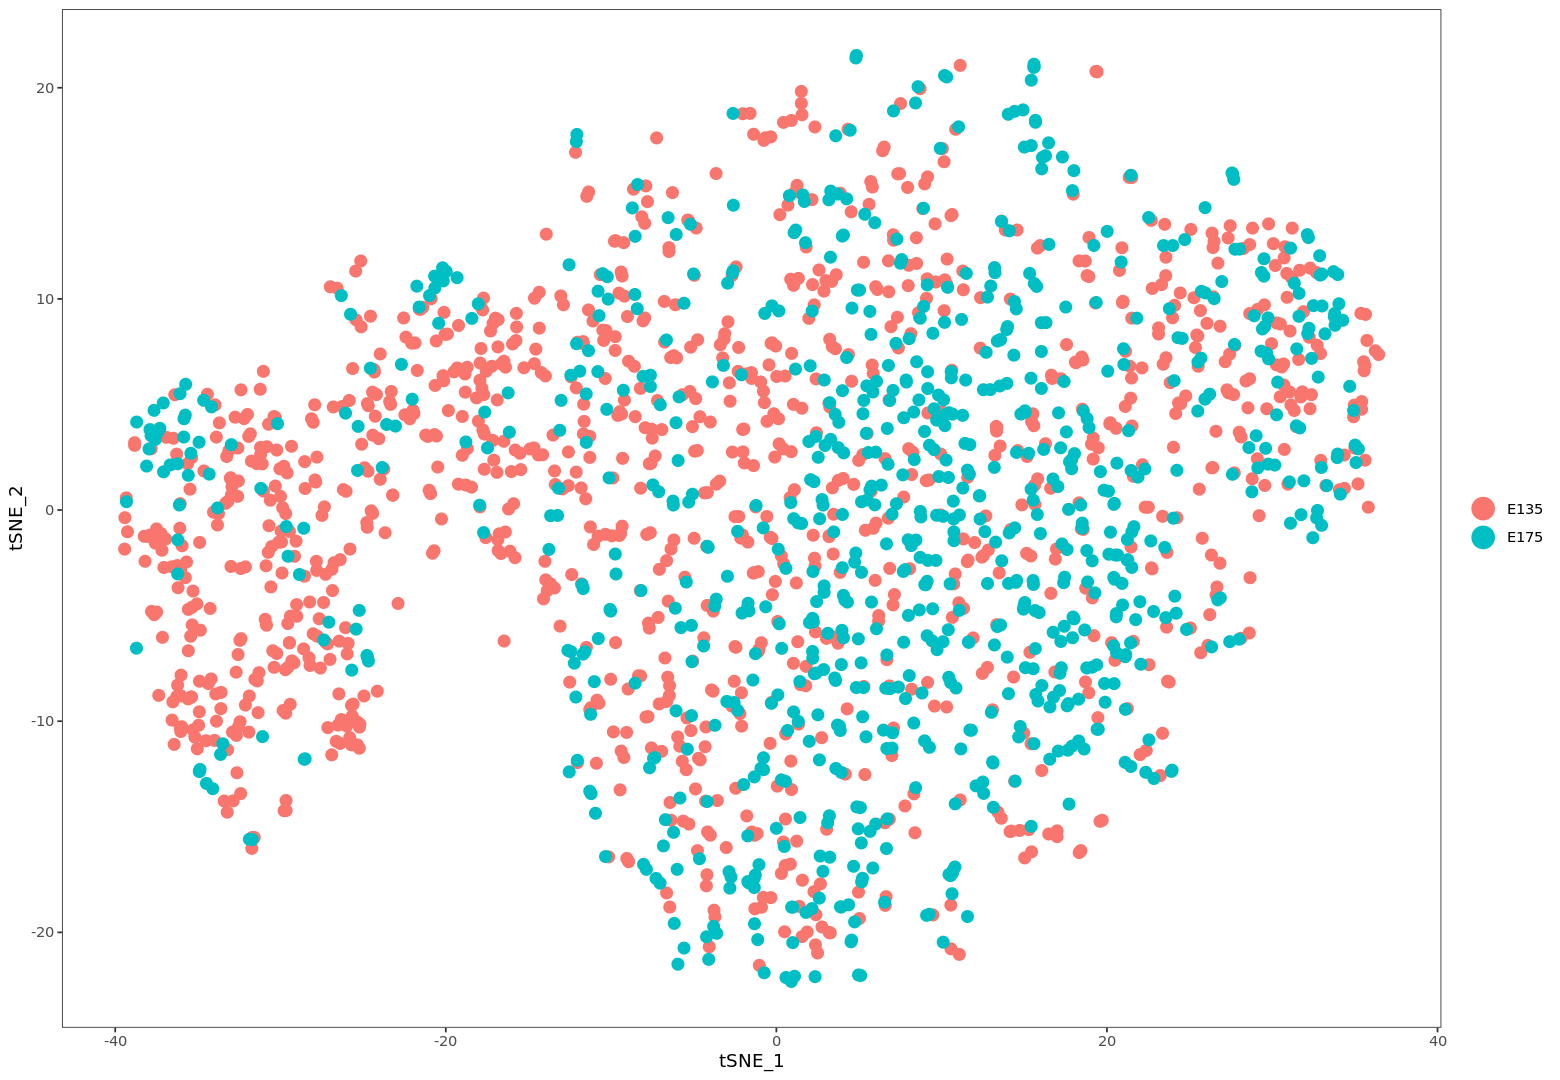

In [33]:
E135_E175_CCA <- RunTSNE(object = E135_E175_CCA, reduction.use = "cca.aligned", dims.use = 1:13, 
    do.fast = TRUE)
E135_E175_CCA <- FindClusters(object = E135_E175_CCA, reduction.type = "cca.aligned", dims.use = 1:13, save.SNN = TRUE, force.recalc = TRUE)
p1 <- TSNEPlot(object = E135_E175_CCA, group.by = "protocol", do.return = TRUE, pt.size = 3)
p2 <- TSNEPlot(object = E135_E175_CCA, do.return = TRUE, pt.size = 3)
plot_grid(p1)

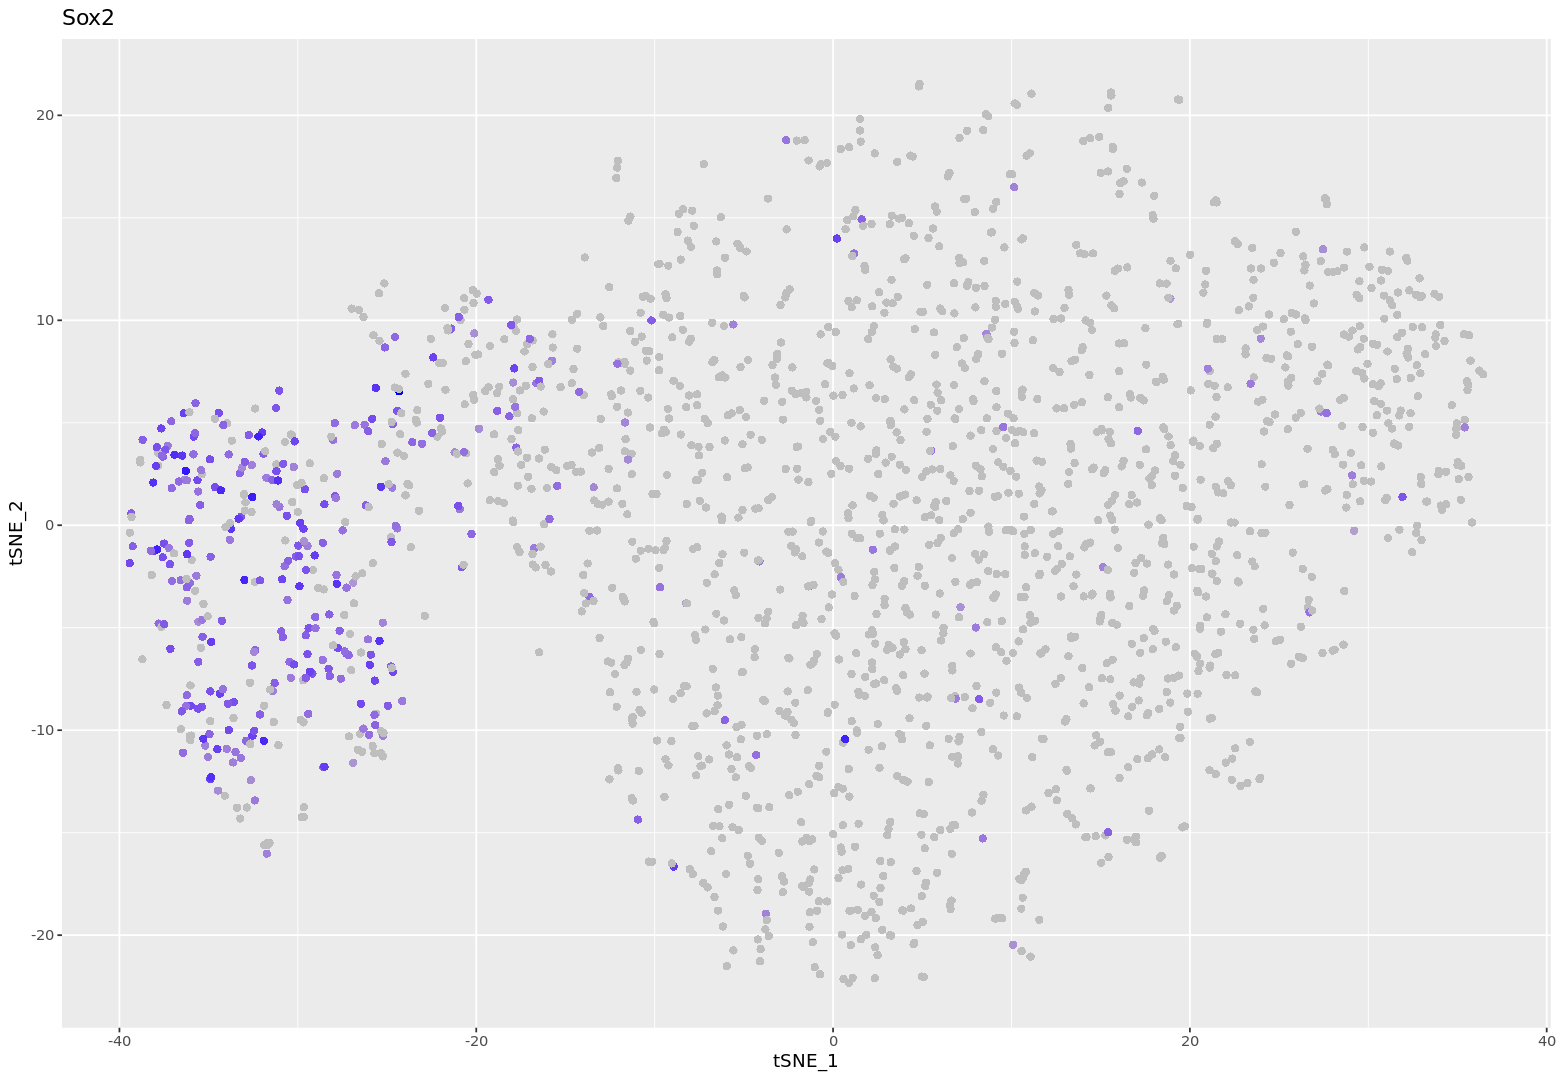

In [36]:
FeaturePlot(object = E135_E175_CCA, features.plot = c('Sox2'), cols.use = c("grey", "blue"), reduction.use = "tsne", pt.size = 2)

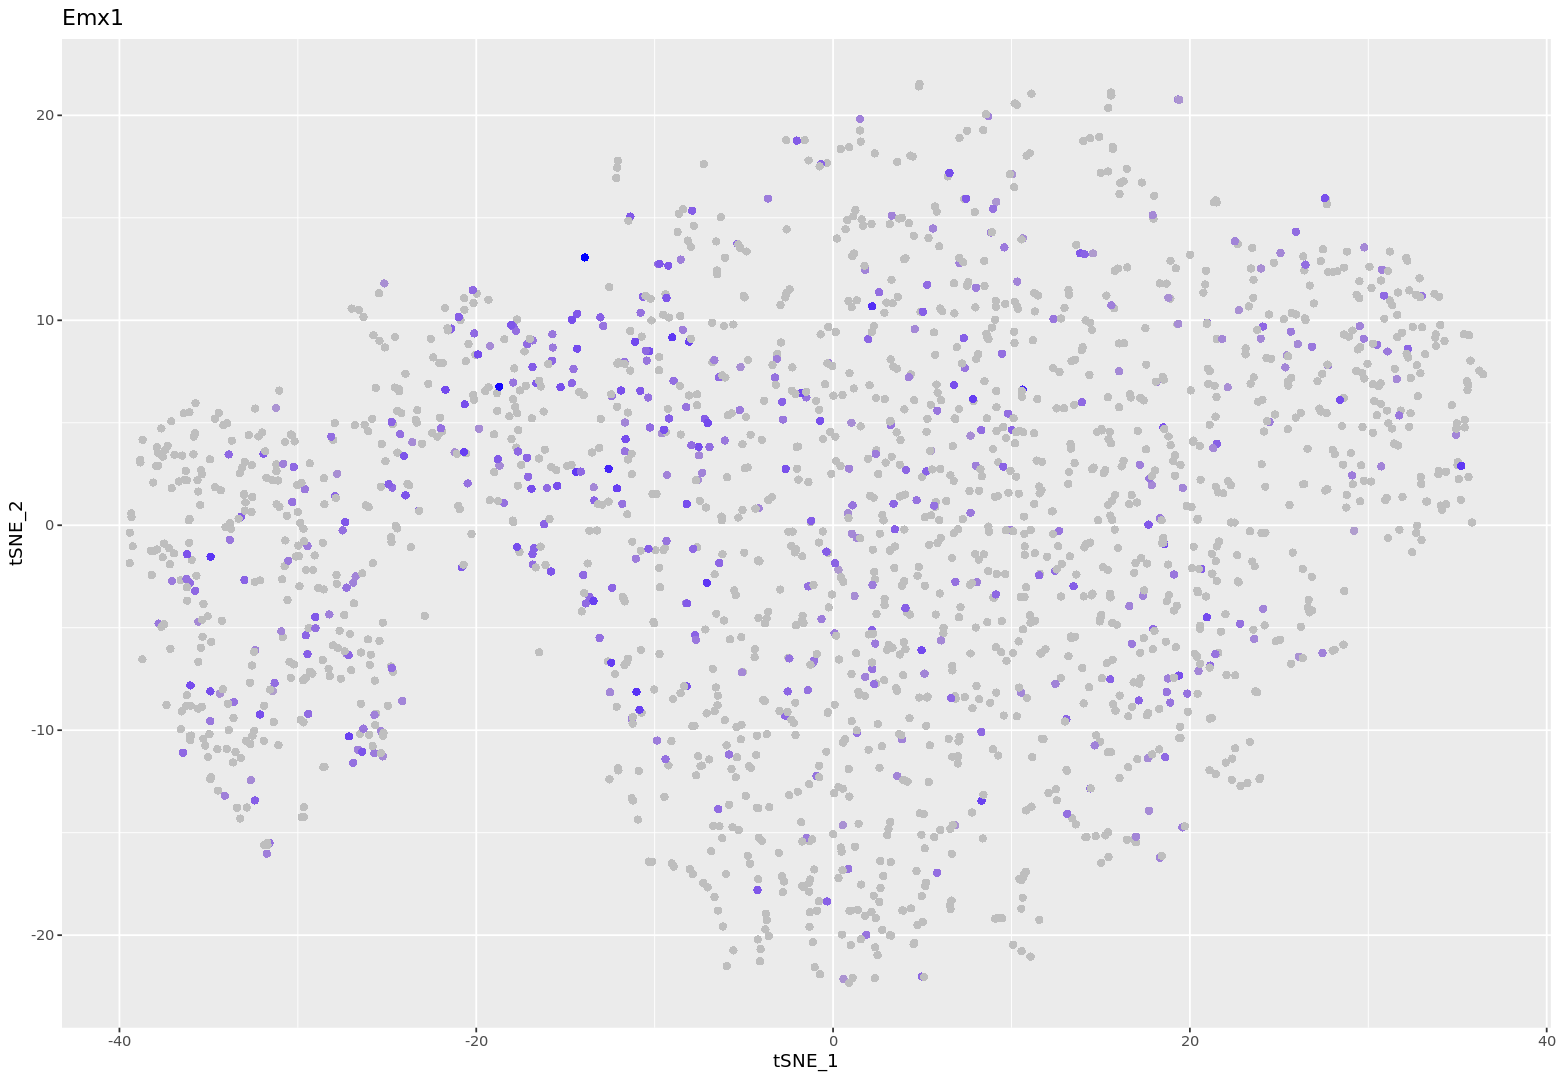

In [37]:
FeaturePlot(object = E135_E175_CCA, features.plot = c('Emx1'), cols.use = c("grey", "blue"), reduction.use = "tsne", pt.size = 2)

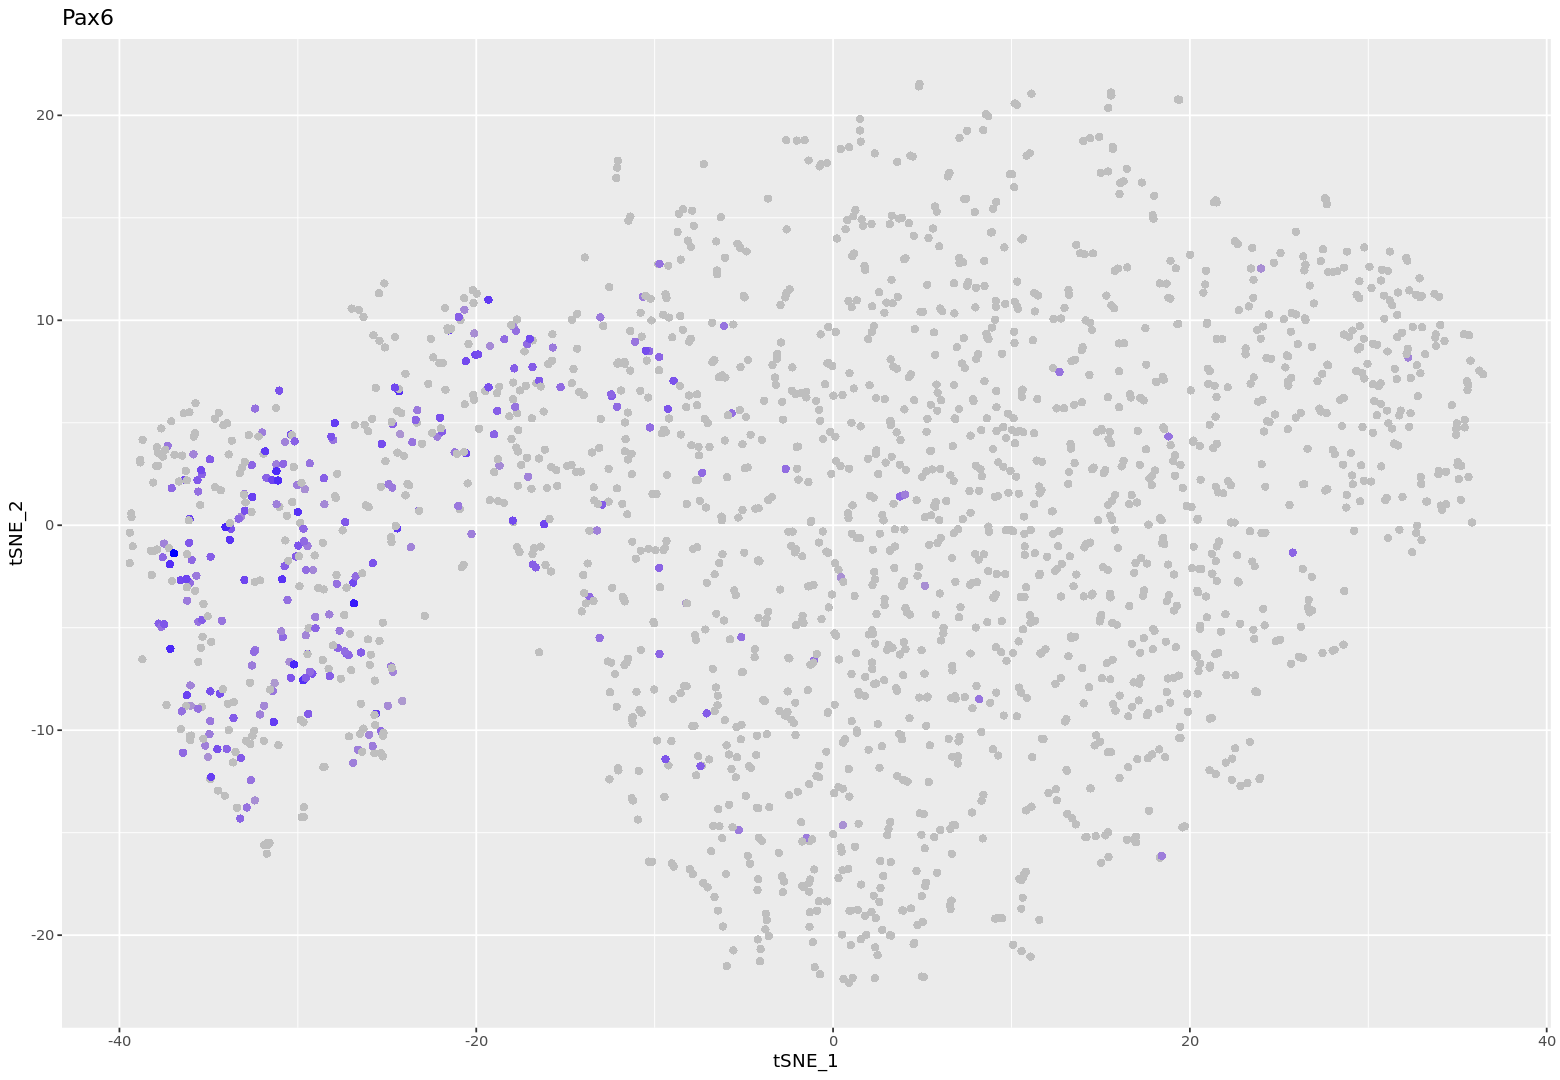

In [38]:
FeaturePlot(object = E135_E175_CCA, features.plot = c('Pax6'), cols.use = c("grey", "blue"), reduction.use = "tsne", pt.size = 2)

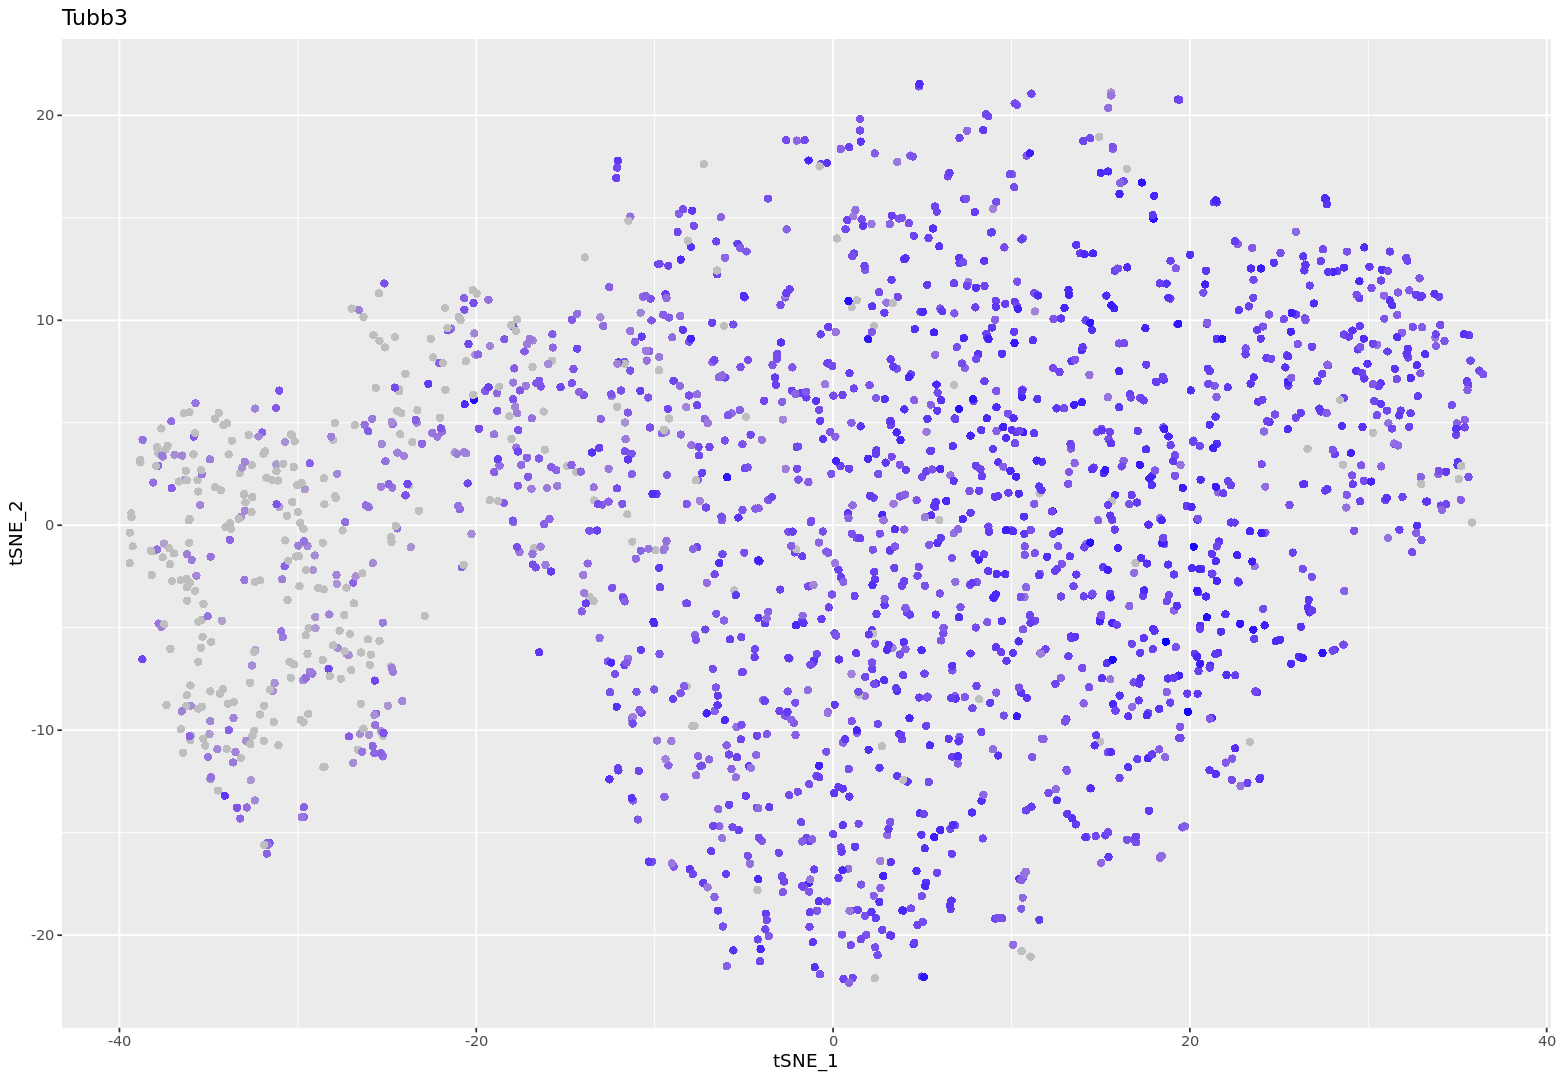

In [39]:
FeaturePlot(object = E135_E175_CCA, features.plot = c('Tubb3'), cols.use = c("grey", "blue"), reduction.use = "tsne", pt.size = 2)

### Finding differentially expressed genes for CombiT
Now we will find the differentially expressed genes between Rps and Neurons. These will be used as input to IntOmix.

#### Get original cell types using Seurat objects for E135 and E175 from previous analysis

In [89]:
E135_Cortical <- readRDS("E135_Cortical.rds")
E175_Cortical <- readRDS("E175_Cortical.rds")
E175_Cortical@meta.data$FriedaPaperIdent <- as.character(E175_Cortical@ident)

In [90]:
table(E135_Cortical@ident)
table(E175_Cortical@ident)


    IPs Neurons     RPs 
    245     656     139 


Neurons     RPs 
    785      71 

In [93]:
E135_E175_CCA@meta.data$cell_type <- sapply(rownames(E135_E175_CCA@meta.data), function(x) {
    dataset <- strsplit(x, "_")[[1]][1]
    cb <- strsplit(x, "_")[[1]][2]
    cell_type <- "filtered"
    if(dataset == "E135")
        if(cb %in% rownames(E135_Cortical@meta.data))
            cell_type <- E135_Cortical@meta.data[cb, "FriedaPaperIdent"]
    if(dataset == "E175")
        if(cb %in% rownames(E175_Cortical@meta.data))
            cell_type <- E175_Cortical@meta.data[cb, "FriedaPaperIdent"]
    return(cell_type)
})

In [94]:
E135_E175_CCA@meta.data$protocol_cell_type <- paste(E135_E175_CCA@meta.data$protocol, E135_E175_CCA@meta.data$cell_type, sep = "_")
head(E135_E175_CCA@meta.data)
table(E135_E175_CCA@meta.data$protocol_cell_type)

nGene nUMI  orig.ident    percent.mito protocol var.ratio.pca
E135_GTAGCAATTTCT 3136   8012 E135_Cortical 0            E135     0.9248625    
E135_TACTAGATGCTA 3608   9935 E135_Cortical 0            E135     0.7395172    
E135_TATCAGCAGATT 3493   9589 E135_Cortical 0            E135     0.7785606    
E135_TACAGGCCCGTC 3736   9866 E135_Cortical 0            E135     0.5636801    
E135_TGATATACACTT 3752  10387 E135_Cortical 0            E135     0.9413411    
E135_ATTTCGCGTGAA 3270   8293 E135_Cortical 0            E135     0.7085136    
                  res.0.8 cell_type protocol_cell_type
E135_GTAGCAATTTCT 4       filtered  E135_filtered     
E135_TACTAGATGCTA 1       filtered  E135_filtered     
E135_TATCAGCAGATT 3       filtered  E135_filtered     
E135_TACAGGCCCGTC 0       filtered  E135_filtered     
E135_TGATATACACTT 0       filtered  E135_filtered     
E135_ATTTCGCGTGAA 4       filtered  E135_filtered


E135_filtered      E135_IPs  E135_Neurons      E135_RPs E175_filtered 
           97           243           649           134            22 
 E175_Neurons      E175_RPs 
          746            61 

In [100]:
str(E135_E175_CCA@meta.data)

'data.frame':	1952 obs. of  9 variables:
 $ nGene             : num  3136 3608 3493 3736 3752 ...
 $ nUMI              : num  8012 9935 9589 9866 10387 ...
 $ orig.ident        : chr  "E135_Cortical" "E135_Cortical" "E135_Cortical" "E135_Cortical" ...
 $ percent.mito      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ protocol          : chr  "E135" "E135" "E135" "E135" ...
 $ var.ratio.pca     : num  0.925 0.74 0.779 0.564 0.941 ...
 $ res.0.8           : chr  "4" "1" "3" "0" ...
 $ cell_type         : chr  "filtered" "filtered" "filtered" "filtered" ...
 $ protocol_cell_type: chr  "E135_filtered" "E135_filtered" "E135_filtered" "E135_filtered" ...


In [101]:
E135_E175_CCA <- SetIdent(E135_E175_CCA, ident.use = E135_E175_CCA@meta.data$protocol_cell_type)
table(E135_E175_CCA@ident)


E135_filtered      E135_IPs  E135_Neurons      E135_RPs E175_filtered 
           97           243           649           134            22 
 E175_Neurons      E175_RPs 
          746            61 

#### Get differentially expressed genes between E17.5 RPs and E13.5 RPs

In [105]:
clusterE175vsE135RPs.markers <- FindMarkers(object = E135_E175_CCA, ident.1 = "E175_RPs", ident.2 = "E135_Neurons", logfc.threshold = 0.005, min.pct = 0.05)
head(clusterE175vsE135RPs.markers)

p_val         avg_logFC pct.1 pct.2 p_val_adj    
Ednrb  1.750280e-115 2.433987  0.754 0.000 2.429038e-111
Mfge8  6.640564e-114 2.638564  0.787 0.005 9.215775e-110
Slc1a3 3.354984e-100 2.688122  0.787 0.015  4.656047e-96
Tnc     4.283454e-92 2.028520  0.607 0.000  5.944578e-88
Aldoc   2.296376e-90 2.478091  0.705 0.012  3.186911e-86
Hes5    9.142850e-90 2.305788  0.623 0.003  1.268845e-85

In [106]:
clusterE175vsE135RPs.markers_intomix <- data.frame(ID = row.names(clusterE175vsE135RPs.markers), pval = clusterE175vsE135RPs.markers$p_val, log2FC = clusterE175vsE135RPs.markers$avg_logFC)
head(clusterE175vsE135RPs.markers_intomix)

ID     pval          log2FC  
1 Ednrb  1.750280e-115 2.433987
2 Mfge8  6.640564e-114 2.638564
3 Slc1a3 3.354984e-100 2.688122
4 Tnc     4.283454e-92 2.028520
5 Aldoc   2.296376e-90 2.478091
6 Hes5    9.142850e-90 2.305788

In [107]:
write.csv(clusterE175vsE135RPs.markers_intomix, "clusterE175vsE135RPs.markers.csv", row.names = F)

### Running IntOmix 
We developed a technique that leverages single-cell RNA sequencing data to infer global metabolic rewiring across different cellular phenotypes at the level of individual genes and metabolites It uses KEGG’s map of enzymes, metabolites and the reactions between them. It uses an algorithm called IntOmix which maps the differential enzymes between two phenotypes in the data on the map and finds a significant subnetwork. This is done by optimising the network to find the maximum weighted subgraph from the entire network.

#### To try intoOmix go to [Polly Intomix](https://resources.elucidata.io/intomix)
Here we show the metabolic subnetwork generated by Intomix for for RPs and Neurons.

### Intomix resuls for 17th day RPs vs 13th day RPs 

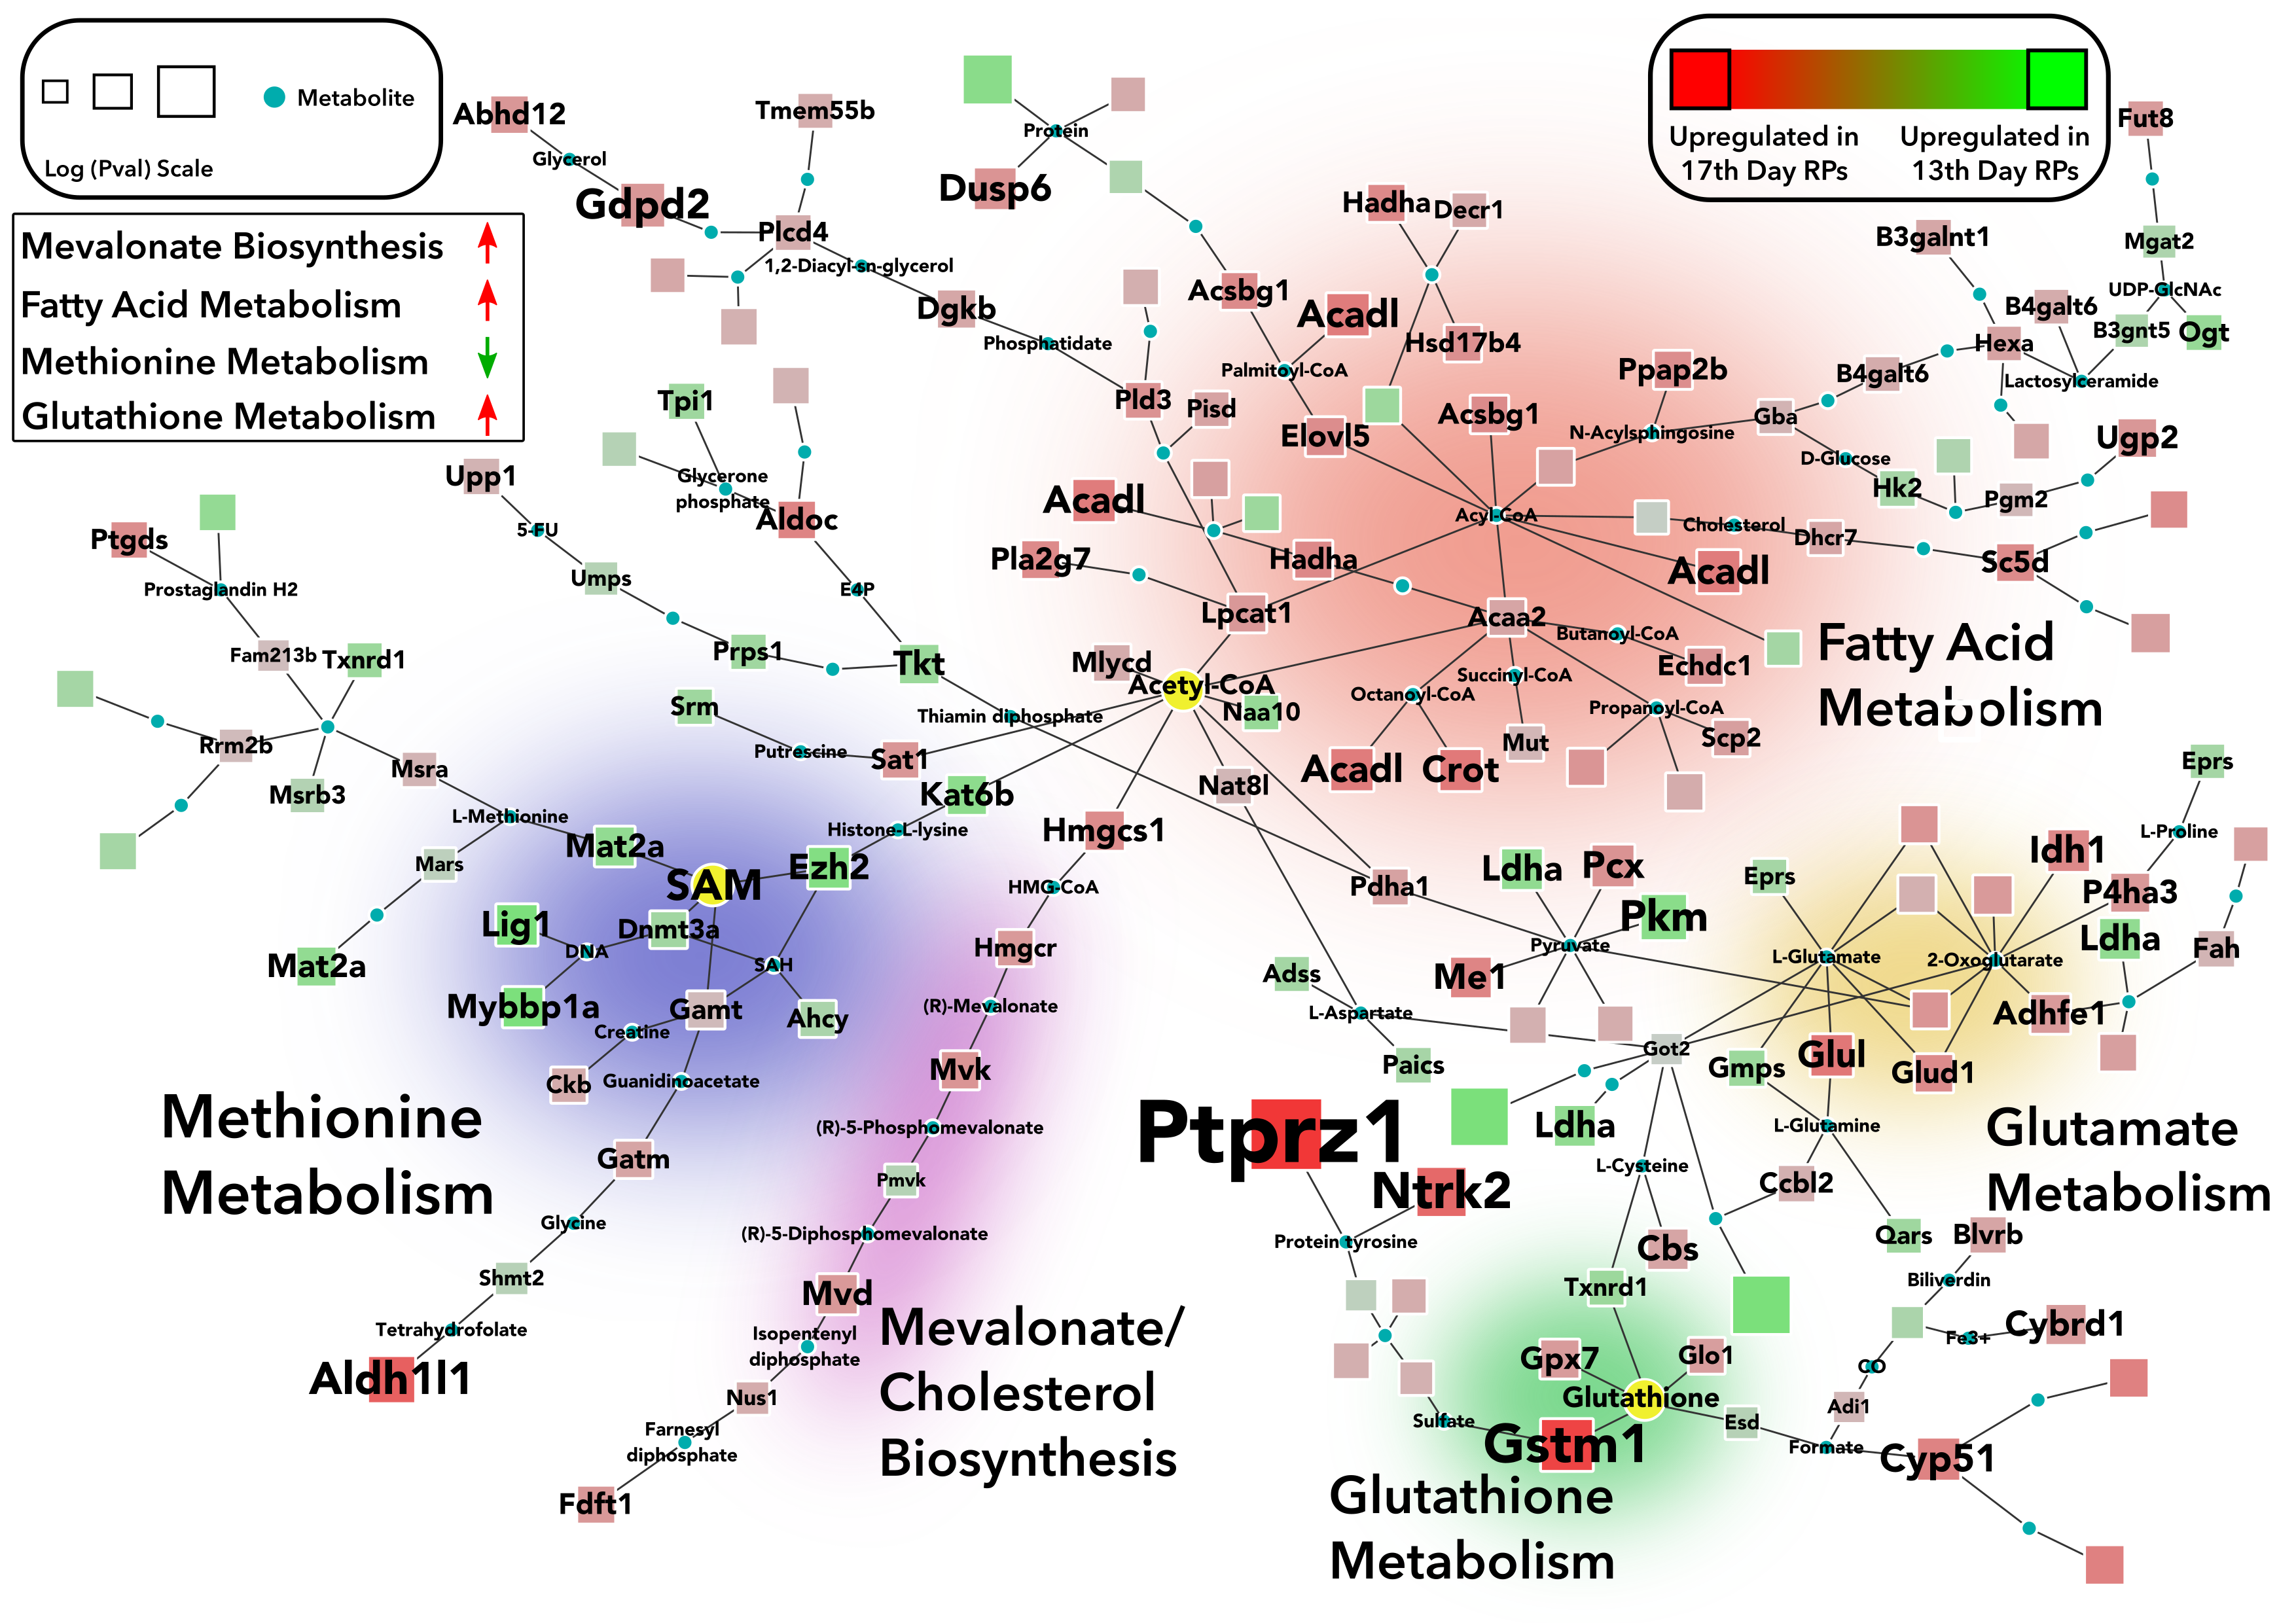

In [111]:
IRdisplay::display_png(file = "E175_RPs_vs_E135_RPs_intomix.png")